#### The explanation for each cell is provided in the markdown section right below the respective code cell.

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
numpy.random.seed(7)

Import required libraries for data handling, math, deep learning, scaling, and evaluation.

Fix seed so results don’t change on every run.

In [2]:
# load the dataset
dataframe = pandas.read_csv('airline_passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Reads the Airline Passengers dataset (only passenger numbers column).

Converts it to float (neural nets need float).

Scales values between 0 and 1 → helps LSTM converge faster and avoid instability.

In [3]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Takes 67% of rows for training, remaining for testing.

Training data → model learns patterns.

Testing data → model is evaluated on unseen data.

## Time Series with LSTM


Now before training the data on the LSTM model, we need to prepare the data so that we can fit it on the model, for this task I will define a helper function:

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Function turns a sequence into X (inputs) and Y (outputs).

With look_back=1, input is value at time t, output is value at t+1.

Creates many such pairs across dataset.

In [5]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

LSTM in Keras requires input in 3D:

samples = number of sequences.

timesteps = length of each input sequence (here = 1).

features = number of features per step (here = 1).

Reshaping ensures input shape matches (samples, 1, 1).

In [6]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

c:\Users\Ritu Vishwakarma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
94/94 - 2s - 23ms/step - loss: 0.0382
Epoch 2/100
94/94 - 0s - 2ms/step - loss: 0.0163
Epoch 3/100
94/94 - 0s - 2ms/step - loss: 0.0123
Epoch 4/100
94/94 - 0s - 2ms/step - loss: 0.0113
Epoch 5/100
94/94 - 0s - 2ms/step - loss: 0.0101
Epoch 6/100
94/94 - 0s - 2ms/step - loss: 0.0091
Epoch 7/100
94/94 - 0s - 2ms/step - loss: 0.0081
Epoch 8/100
94/94 - 0s - 2ms/step - loss: 0.0072
Epoch 9/100
94/94 - 0s - 2ms/step - loss: 0.0064
Epoch 10/100
94/94 - 0s - 2ms/step - loss: 0.0056
Epoch 11/100
94/94 - 0s - 2ms/step - loss: 0.0049
Epoch 12/100
94/94 - 0s - 3ms/step - loss: 0.0043
Epoch 13/100
94/94 - 0s - 2ms/step - loss: 0.0038
Epoch 14/100
94/94 - 0s - 2ms/step - loss: 0.0034
Epoch 15/100
94/94 - 0s - 2ms/step - loss: 0.0030
Epoch 16/100
94/94 - 0s - 2ms/step - loss: 0.0027
Epoch 17/100
94/94 - 0s - 2ms/step - loss: 0.0026
Epoch 18/100
94/94 - 0s - 2ms/step - loss: 0.0024
Epoch 19/100
94/94 - 0s - 2ms/step - loss: 0.0023
Epoch 20/100
94/94 - 0s - 2ms/step - loss: 0.0022
Epoch 21

Sequential model → layers stacked.

LSTM with 4 neurons → captures sequential patterns.

Dense layer with 1 neuron → predicts the next value.

Loss = MSE (good for regression). Optimizer = Adam.

Trains for 100 epochs, updating weights after each sample (batch_size=1).

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


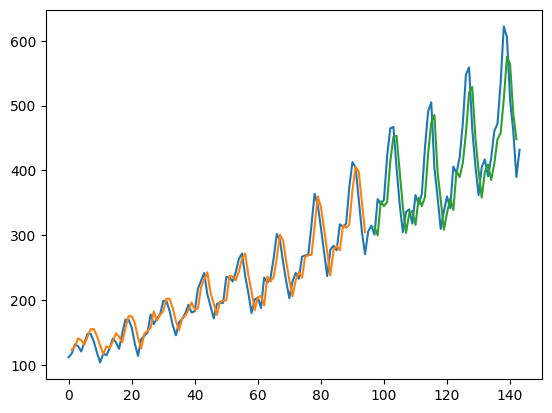

In [7]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



Converts predictions and targets back to original passenger scale.

Calculates RMSE for train & test sets → error in original units (passenger numbers).

Creates arrays filled with NaN values (placeholders).

Inserts train/test predictions at the correct positions, aligning them with actual data.

Plots the original passenger data (blue).

Plots train predictions (green).

Plots test predictions (red).

Shows how well the LSTM learned and how well it forecasts unseen data.